Before the introduction of this section, I should explain the short-term component $\alpha_t$:

- In a market, 
<center>

if buy MOs arrive => $\alpha$ increase

if sell MOs arrive => $\alpha$ decrease
</center>

So, $\alpha_t$ satisfies that (eq 10.31)
$$
d\alpha_t = -\zeta\alpha_tdt+\eta dW_t^\alpha+\epsilon^{+}_{1+M^+_{t^-}}dM_t^+-\epsilon^{-}_{1+M^-_{t^-}}dM_t^-
$$
where 
- $\{\epsilon^{+},...,\epsilon^{-},...\}$ represents the jump in alpha when a market sell/buy order arrives. and they are iid.
In code, for simplicity, set $\epsilon = 0.002$.
- we use $\lambda_p, \lambda_m$ to represent the arrival rate of market orders and we set $\lambda_p=\lambda_m = 0.8333$.
- W denotes the Brownian motion.
- In code, we use the following eqution to calculate the difference of $\alpha$ $$d\alpha = \sqrt{(\eta^2 + \epsilon^2(\lambda_p + \lambda_m))dt}.$$

In [1]:
import numpy as np
import math
class ShortTermAlpha:

    def __init__(self, zeta, epsilon, eta):
        self.zeta = zeta
        self.epsilon = epsilon
        self.eta = eta
        self.dalpha = None
        self.value = None

    def generate_dalpha(self, dt, lambda_p, lambda_m):
        self.dalpha = math.sqrt((self.eta ** 2 + self.epsilon ** 2 * (lambda_p + lambda_m))  *3* dt)

    def generate_alpha(self, alpha_threshold, decimal_places=4):
        if self.dalpha is not None:
            max_alpha = math.ceil(alpha_threshold / self.dalpha) * self.dalpha
            min_alpha = -max_alpha
            self.value = np.round(np.arange(min_alpha, max_alpha + self.dalpha, self.dalpha), decimal_places)

As shown in  Chapter 10.4.2, we will solve this following PDE

\begin{align*}
0 = \big ( \partial_t - \zeta \alpha \partial_{\alpha} + \tfrac{1}{2}\eta^2 \partial_{\alpha \alpha}  \big )h + \alpha q - \phi q^2 \hspace{15em}
\\
+ \lambda^{p} \max\limits_{\ell^+\in \{0,1\}} \left\{ \textbf{1}_{q > \underline{q}} \mathbb{E}\big [\ell^+ \tfrac{\Delta}{2} + h(t, \alpha + \epsilon^+, q - \ell^+) - h(t, \alpha + \epsilon^+, q) \big ] \right \} 
\\
+ \lambda^{m} \max\limits_{\ell^-\in \{0,1\}} \left\{ \textbf{1}_{q < \overline{q}} \mathbb{E}\big [\ell^- \tfrac{\Delta}{2} + h(t, \alpha - \epsilon^-, q + \ell^-) - h(t, \alpha - \epsilon^-, q) \big ] \right \} 
\\
+ \lambda^{p} \mathbb{E}[h(t, \alpha + \epsilon^+, q) - h(t, \alpha, q)] + \lambda^{m} \mathbb{E}[h(t, \alpha - \epsilon^-, q) - h(t, \alpha, q)] ,
\end{align*}

subject to the terminal condition

\begin{equation*}
h(T, \alpha, q) = -q (\tfrac{\Delta}{2} + \varphi q)
\end{equation*}

The exceptation $\mathbb{E}$ is with respect to the random jump size $\epsilon$.

We use interpolate/extrapolate method is calculate $\mathbb{E}[h(t,\alpha+\epsilon\ or\ \alpha-\epsilon,q)]$.

In [2]:
def linear_extrapolation(x, y, e):
    """ Extrapolation and interpolation
    
    :param x: a numpy array
    :param y: a numpy array
    :param e: a numpy array, equivalent of x
    :return: a numpy array
    
    compute the optimal strategy over the time interval [t,t+dt) Eq. (10.32)
    interpolate/extrapolate to alpha + eta
    h_p2 = linear_extrapolation(alpha, h[k, :, i + 1], alpha_up)
    """
    new_x = np.sort(x)
    new_y = y[np.argsort(x)]

    def point_wise(ep):
        if ep < new_x[0]:
            return new_y[0] + (ep - new_x[0]) * (new_y[1] - new_y[0]) / (new_x[1] - new_x[0])
        elif ep > new_x[-1]:
            return new_y[-1] + (ep - new_x[-1]) * (new_y[-1] - new_y[-2]) / (new_x[-1] - new_x[-2])
        else:
            return np.interp([ep], x, y)[0]

    return np.array([point_wise(i) for i in e])

The trader's optimal postings can be characterised as
\begin{equation*}
\ell^{+,*}(t,q,\alpha) = \textbf{1}_{\big \{ \frac{\Delta}{2} + \mathbb{E}[h(t, \alpha + \epsilon^+, q-1) - h(t, \alpha + \epsilon^+, q)] > 0 \big \} \cap \big \{ q > \underline{q} \big \}} ,
\end{equation*}

\begin{equation*}
\ell^{-,*}(t,q,\alpha) = \textbf{1}_{\big \{ \frac{\Delta}{2} + \mathbb{E}[h(t, \alpha - \epsilon^-, q+1) - h(t, \alpha - \epsilon^-, q)] > 0 \big \} \cap \big \{ q < \overline{q} \big \}} .
\end{equation*}

$\ell^+ = 1$ means that the trader choose to sell his good. So the inventory $q$ becomes $q-1$ and there are arrivals of buy MOs  which means $\alpha+\epsilon^+$. 

$\Delta$ is the spread of the market and we think it is reasonable that $\frac{\Delta}{2}$ is the profit in one deal. 

### Sample Results
For the purpose of focusing on the effect of short-term-alpha, we set the running penalty $\phi = 0$, and the remaining model parameters are
\begin{equation*}
T = 60sec, \overline{q} = -\underline{q}=20, \lambda^{\pm} = 0.8333, \Delta = 0.01, \varphi = 0.01
\end{equation*}

\begin{equation*}
\eta = 0.001, \zeta = 0.5, \epsilon = 0.002 (constant)
\end{equation*}

In [3]:
T = 60
Nq = 20

# Inventory Vector
q = np.arange(-Nq, Nq + 1, 1)

# Short-term alpha parameters
zeta = 0.5
epsilon = 0.002
eta = 0.001

Delta = 0.01
varphi = 0.01

# Running penalty
phi = 0

# Price volatility
sigma = 0.005

lambda_p = 0.8333
lambda_m = 0.8333

Ndt = math.floor((lambda_p + lambda_m) * T * 5)

dt = T / Ndt
# Time Vector
t = np.arange(0, T + dt, dt)

In [4]:
short_term_alpha = ShortTermAlpha(zeta, epsilon, eta)
short_term_alpha.generate_dalpha(dt, lambda_p, lambda_m)
short_term_alpha.generate_alpha(0.02, 4)

In [5]:
def generate_h_matrix(short_term_alpha, q, t, Delta, varphi, dt, phi, lambda_p, lambda_m):
    """ Solves the DPE on page 269.
    
    :param short_term_alpha: a short_term_alpha object
    :param q: an inventory vector
    :param t: a time 
    :param Delta: spread
    :param varphi: variable = 0.01
    :param dt: variable
    :param phi: variable = 0
    :param lambda_p: a numpy vector 0.8333
    :param lambda_m: a numpy vector 0.8333
    :return: h value matrix, l+ and l- of Equation 10.32
    """
    # set up the time, inventory, and space grids
    dalpha = short_term_alpha.dalpha
    alpha = short_term_alpha.value
    eta = short_term_alpha.eta
    zeta = short_term_alpha.zeta
    Nalpha = alpha.shape[0]
    epsilon = short_term_alpha.epsilon
    alpha_up = alpha + epsilon
    alpha_down = alpha - epsilon
    d_alpha_h = np.zeros(Nalpha)

    Nt = t.shape[0]
    Nq = q.shape[0]

    # stores the h as a function of q, alpha, t      h = h(q,\alpha,t)
    h = np.full((Nq, Nalpha, Nt), fill_value=np.nan)
    # Terminal conditions for all q. It just depends on q.
    h[:, :, h.shape[-1] - 1]= np.around((-(0.5 * Delta * np.sign(q) + varphi * q) * q), decimals=4)[:, np.newaxis]
    
    # stores the optimal posting strategies as a function of q, alpha, t
    # lp means \ell^+
    # lm means \ell^-
    lp = np.zeros((Nq, Nalpha, Nt), dtype=bool)
    lm = np.zeros((Nq, Nalpha, Nt), dtype=bool)

    # Index of alpha smaller than 0
    idx_m = np.where(alpha < 0)[0]
    # Index of alpha greater than 0
    idx_p = np.where(alpha > 0)[0]
    # Index of alpha equals to 0
    idx_0 = np.where(alpha == 0)[0]

    for i in range(h.shape[2] - 2, -1, -1):
        # Solve the HJB in the continuation region  backward from t + dt to t. 
        
        if i % 50 == 0 :
            print(math.floor(10*(i/h.shape[2])))

        # k is the index of Nq
        for k in range(0, h.shape[0], 1):
            # compute the optimal strategy over the time interval [t,t+dt) Eq. (10.32)
            # interpolate/extrapolate to alpha + eta 
            # h_p2 = E[h(q , \alpha + \epsilon^+, t)]    notice alpha_up = alpha + epsilon^+
            h_p2 = linear_extrapolation(alpha, h[k, :, i + 1], alpha_up)
            if q[k] > -(Nq - 1) / 2:
                h_p1 = linear_extrapolation(alpha, h[k - 1, :, i + 1], alpha_up)
                post_h_p = 0.5 * Delta + h_p1 - h_p2
            else:
                post_h_p = np.zeros(Nalpha)
            lp[k, :, i + 1] = post_h_p > 0
            # interpolate/extrapolate to alpha - eta
            h_m2 = linear_extrapolation(alpha, h[k, :, i + 1], alpha_down)
            if q[k] < (Nq - 1) / 2:
                h_m1 = linear_extrapolation(alpha, h[k + 1, :, i + 1], alpha_down)
                post_h_m = 0.5 * Delta + h_m1 - h_m2
            else:
                post_h_m = np.zeros(Nalpha)
            lm[k, :, i + 1] = post_h_m > 0

            # forward difference
            d_alpha_h[idx_m] = (h[k, idx_m + 1, i + 1] - h[k, idx_m, i + 1]) / dalpha
            # backward difference
            d_alpha_h[idx_p] = (h[k, idx_p, i + 1] - h[k, idx_p - 1, i + 1]) / dalpha
            # centre difference
            d_alpha_h[idx_0] = (h[k, idx_0 + 1, i + 1] - h[k, idx_0 - 1, i + 1]) / (2 * dalpha)

            d2_alpha_h = (h[k, 2:h.shape[1], i + 1] - 2 * h[k, 1:(h.shape[1] - 1), i + 1] + h[k, 0:(h.shape[1] - 2),i + 1]) / (dalpha ** 2)

            h[k, 1:(h.shape[1] - 1), i] = h[k, 1:(h.shape[1] - 1), i + 1] + dt * ( -zeta * alpha[1:(alpha.shape[0] - 1)] * d_alpha_h[1:(d_alpha_h.shape[0] - 1)]
                                                                                  + 0.5 * (eta ** 2) * d2_alpha_h
                                                                                  + zeta * alpha[1:(alpha.shape[0] - 1)] * q[k] - phi * (q[k] ** 2)
                                                                                  + lambda_p * np.maximum(post_h_p[1:(post_h_p.shape[0] - 1)], 0)
                                                                                  + lambda_m * np.maximum(post_h_m[1:(post_h_m.shape[0] - 1)], 0)
                                                                                  + lambda_p * (h_p2[1:(h_p2.shape[0] - 1)] - h[k, 1:(h.shape[1] - 1), i + 1])
                                                                                  + lambda_m * (h_m2[1:(h_m2.shape[0] - 1)] - h[k, 1:(h.shape[1] - 1), i + 1]))
            # the boundary conditions
            h[k, 0, i] = 2 * h[k, 1, i] - h[k, 2, i]
            h[k, h.shape[1] - 1, i] = 2 * h[k, h.shape[1]-2, i] - h[k, h.shape[1]-3, i]
    print("done !")
    return h, lp, lm

h, lp, lm = generate_h_matrix(short_term_alpha, q, t, Delta, varphi, dt, phi, lambda_p, lambda_m)
    

8
7
6
5
4
3
2
1
0
0
done !


- h[:, :, h.shape[-1] - 1]= np.around((-(0.5 * Delta * np.sign(q) + varphi * q) * q), decimals=4)[:, np.newaxis]

In [46]:
dalpha = short_term_alpha.dalpha
alpha = short_term_alpha.value
eta = short_term_alpha.eta
zeta = short_term_alpha.zeta
Nalpha = alpha.shape[0]
epsilon = short_term_alpha.epsilon
alpha_up = alpha + epsilon
alpha_down = alpha - epsilon

Nt = t.shape[0]
Nq = q.shape[0]
h = np.full((Nq, Nalpha, Nt), fill_value=np.nan)
h[:, :, h.shape[-1] - 1]= np.around((-(0.5 * Delta * np.sign(q) + varphi * q) * q), decimals=4)[:, np.newaxis]
h[:, :, h.shape[-1] - 1]

array([[-4.1  , -4.1  , -4.1  , ..., -4.1  , -4.1  , -4.1  ],
       [-3.705, -3.705, -3.705, ..., -3.705, -3.705, -3.705],
       [-3.33 , -3.33 , -3.33 , ..., -3.33 , -3.33 , -3.33 ],
       ...,
       [-3.33 , -3.33 , -3.33 , ..., -3.33 , -3.33 , -3.33 ],
       [-3.705, -3.705, -3.705, ..., -3.705, -3.705, -3.705],
       [-4.1  , -4.1  , -4.1  , ..., -4.1  , -4.1  , -4.1  ]])

- Upwind Scheme

- The rough idea is to use a forward difference approximation whenever the drift of the state variable $\alpha$ from the term $-\zeta \alpha \partial_{\alpha}h$ is negative and to use a backwards difference whenever it is positive.

- forward difference:  $\alpha < 0$
$$
\frac{dh(q,\alpha,t)}{d\alpha}=(h(q, \alpha + d\alpha, t) - h(q, \alpha, t)) / d\alpha
$$

- backword difference: $\alpha > 0$
$$
\frac{dh(q,\alpha,t)}{d\alpha}=(h(q, \alpha, t) - h(q, \alpha-d\alpha, t)) / d\alpha
$$

In [28]:
def generate_sell_buy_posts(short_term_alpha, t, q, lp, lm):
    Nt = t.shape[0]
    Nalpha = short_term_alpha.value.shape[0]
    lp_b = np.full((Nalpha, Nt), np.NaN)
    lm_b = np.full((Nalpha, Nt), np.NaN)

    for k in range(0, Nt):
        for  j in range(0, Nalpha):
            # find out the index of lp[:,j,k] = 1. It means the trader makes a sell order
            idx = np.where(lp[:, j, k] == 1)[0]
            print("j:",j)
            print(idx)
            if idx.size != 0:
                # First Index        
                idx = idx[0]
                lp_b[j, k] = q[idx]
            idx1 = np.where(lm[:, j, k] == 1)[0]
            print("j:",j)
            print(idx1)
            if idx1.size != 0:
                # Last Index
                idx1 = idx1[-1]
                lm_b[j, k] = q[idx1]
    return lp_b, lm_b, idx1

In [29]:
lp_b, lm_b, idx1 =generate_sell_buy_posts(short_term_alpha, t, q, lp, lm)

j: 0
[]
j: 0
[]
j: 1
[]
j: 1
[]
j: 2
[]
j: 2
[]
j: 3
[]
j: 3
[]
j: 4
[]
j: 4
[]
j: 5
[]
j: 5
[]
j: 6
[]
j: 6
[]
j: 7
[]
j: 7
[]
j: 8
[]
j: 8
[]
j: 9
[]
j: 9
[]
j: 10
[]
j: 10
[]
j: 11
[]
j: 11
[]
j: 12
[]
j: 12
[]
j: 13
[]
j: 13
[]
j: 14
[]
j: 14
[]
j: 15
[]
j: 15
[]
j: 16
[]
j: 16
[]
j: 17
[]
j: 17
[]
j: 18
[]
j: 18
[]
j: 19
[]
j: 19
[]
j: 20
[]
j: 20
[]
j: 21
[]
j: 21
[]
j: 22
[]
j: 22
[]
j: 23
[]
j: 23
[]
j: 24
[]
j: 24
[]
j: 25
[]
j: 25
[]
j: 26
[]
j: 26
[]
j: 0
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
j: 0
[]
j: 1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
j: 1
[]
j: 2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
j: 2
[0]
j: 3
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 4

C:\User\Shen\AppData\Local\Temp\ipykernel_16980\349089468.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


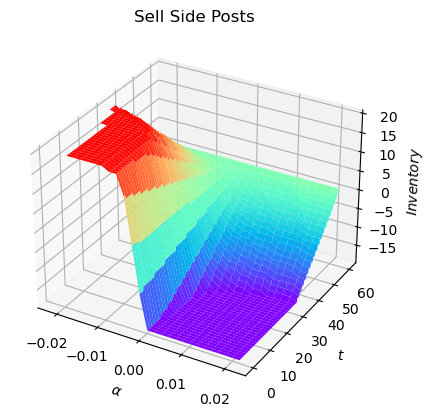

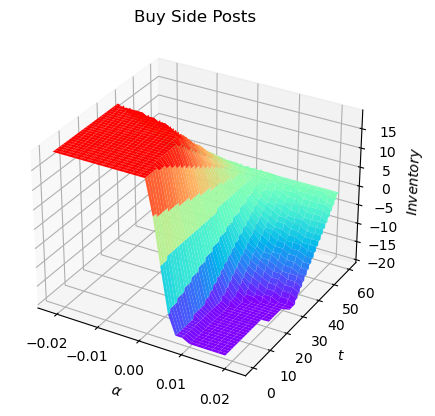

In [23]:
import matplotlib.pyplot as plt
def plot_post_surface(t, alpha, inventory, q, title):
    x, y = np.meshgrid(alpha, t)
    # x.shape = y.shape = (501,27) 
    z = np.transpose(inventory)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x, y, z, cmap='rainbow')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$t$')
    ax.set_zlabel(r'$Inventory$')
    plt.title(label=title)
    plt.show()
plot_post_surface(t, np.flip(short_term_alpha.value), lp_b, q, title="Sell Side Posts")
plot_post_surface(t, np.flip(short_term_alpha.value), lm_b, q, title="Buy Side Posts")
    

In [20]:
lm_b

array([[ nan,  nan,  nan, ..., -20., -20., -20.],
       [ nan,  nan,  nan, ..., -20., -20., -20.],
       [ nan, -20., -20., ..., -20., -20., -20.],
       ...,
       [ nan, -20., -20., ..., -20., -20., -20.],
       [ nan, -20., -20., ..., -20., -20., -20.],
       [ nan, -20., -20., ..., -20., -20., -20.]])